In [3]:
# For testing
task_type_list = ['regression', 'classification', 'clustering']

# for task_type in task_type_list:
    
#     if task_type == 'regression':
#         p

#     elif task_type == 'classification':
#         p

#     elif task_type == 'clustering':
#         p


# **1. Library Importing**

In [4]:
import os
import time
import datetime
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging  # Untuk mencatat proses optimasi
import plotly.graph_objects as go  # Untuk visualisasi interaktif (opsional)


from scipy.stats import shapiro
from scipy.optimize import rosen  # Contoh fungsi objektif standar (opsional)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance

from joblib import Parallel, delayed
import json
from sklearn.model_selection import cross_val_score



from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score,

    accuracy_score,
    precision_score,
    recall_score,
    f1_score,

    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

from mealpy import FloatVar, StringVar, IntegerVar, BoolVar, MixedSetVar, Problem, ACOR, GA, PSO, SA

# **2. Dataset**

In [5]:
def load_data(filepath):
    return pd.read_csv(filepath)

In [6]:
# Test load data

for task_type in task_type_list:
    
    if task_type == 'regression':
        df = load_data("./data/insurance.csv")
        df_reg = df
    
    elif task_type == 'classification':
        df = load_data("./data/iris.csv")
        df_clf = df
    
    elif task_type == 'clustering':
        df = load_data("./data/Mall_Customers.csv")
        df_cls = df

    print(df.head(), '\n')

df_list = [df_reg, df_clf, df_cls]
task_df_zip = zip(task_type_list, df_list)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520 

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa 

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1       

# **3. PREPROCESSING**

In [7]:
def preprocessing(data, task_type, label=None):

    # If there's no label input
    if label is None:
        label = data.columns[-1]

    cleaned_data = data_cleaning(data, task_type, label)
    transformed_data = data_transformation(cleaned_data, task_type, label)
    
    return transformed_data

In [29]:
# Test Preprocessing

preprocessed_df_list = []

for task_type, df in zip(task_type_list, df_list):

    print("\nBefore preprocessing:\n", df.head(), '\n')

    if task_type == 'regression':
        preprocessed_df_reg = preprocessing(df, task_type)
        print("After preprocessing (data):\n", preprocessed_df_reg, '\n')
        preprocessed_df_list.append(preprocessed_df_reg)
        
    elif task_type == 'classification':
        preprocessed_df_clf = preprocessing(df, task_type)
        print("After preprocessing (data):\n", preprocessed_df_clf, '\n')
        preprocessed_df_list.append(preprocessed_df_clf)
        
    elif task_type == 'clustering':
        preprocessed_df_cls = preprocessing(df, task_type)
        print("After preprocessing (data):\n", preprocessed_df_cls, '\n')
        preprocessed_df_list.append(preprocessed_df_cls)
        



Before preprocessing:
    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520 

After preprocessing (data):
 [          age       sex       bmi  children    smoker    region
0    0.347385  1.023333 -0.447469  0.766327 -0.342193  1.374625
1    1.058097  1.023333  1.629846 -0.059748 -0.342193  1.374625
2    1.768810 -0.977199  1.536196  1.592401 -0.342193  0.467087
3    0.631670  1.023333  0.029292  0.766327 -0.342193  1.374625
4   -0.079043  1.023333 -1.516776  1.592401 -0.342193  0.467087
..        ...       ...       ...       ...       ...       ...
949  1.200240 -0.977199  2.023174 -0.885822 -0.342193  0.467087
950  0.205242  1.023333  1.217788  0.766327 -0.3

## 3.1 Data Cleaning

In [8]:
def data_cleaning(data, task_type, label=None): #, alpha, threshold):
    # If there's no label input
    if label is None:
        label = data.columns[-1]
    
    # NA
    data.dropna()

    # Remove duplicates
    data.drop_duplicates()

    # Handle outliers (IQR)
    data = handling_outliers(data) #, alpha) # requires alpha value (default: 0.05)

    # Handle ID-like column
    data = handling_id_cols(data, label) #, threshold) # requires threshold (default: 0.99)
    
    return data

In [9]:
# Test dropna and drop_duplicates
for task_type in task_type_list:
    
    if task_type == 'regression':
        print("Before dropna()", df_reg.empty)
        df_reg.dropna()
        print("After dropna()", df_reg.empty, '\n')

        print("Before drop_duplicates()", len(df_reg.duplicated()))
        df_reg.drop_duplicates()
        print("After drop_duplicates()", len(df_reg.duplicated()), '\n')

    elif task_type == 'classification':
        print("Before dropna()", df_clf.empty)
        df_clf.dropna()
        print("After dropna()", df_clf.empty, '\n')

        print("Before drop_duplicates()", len(df_clf.duplicated()))
        df_clf.drop_duplicates()
        print("After drop_duplicates()", len(df_clf.duplicated()), '\n')

    elif task_type == 'clustering':
        print("Before dropna()", df_cls.empty)
        df_cls.dropna()
        print("After dropna()", df_cls.empty, '\n')

        print("Before drop_duplicates()", len(df_cls.duplicated()))
        df_cls.drop_duplicates()
        print("After drop_duplicates()", len(df_cls.duplicated()), '\n')

Before dropna() False
After dropna() False 

Before drop_duplicates() 1338
After drop_duplicates() 1338 

Before dropna() False
After dropna() False 

Before drop_duplicates() 150
After drop_duplicates() 150 

Before dropna() False
After dropna() False 

Before drop_duplicates() 200
After drop_duplicates() 200 



In [28]:
# Test data_cleaning
for task_type, df in zip(task_type_list, df_list):
    print("Before data_cleaning\n", df, '\n')
    cleaned_data = data_cleaning(df, task_type)
    print("After data_cleaning\n", cleaned_data, '\n')

Before data_cleaning
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns] 

After data_cleaning
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  1688

### 3.1.1 Handling Outliers

In [11]:
def handling_outliers(df, alpha=0.05):
    """
    Handles outliers by dropping the records containing outlier(s).

    Parameters:
        df (pd.DataFrame): The input dataframe.
        alpha (float): The alpha value as the threshold to determine the normality of a data (default: 0.05).
    
    Returns:
        pd.DataFrame: The dataframe with records containing outlier(s) removed.
    """
    numeric_features = df.select_dtypes(include=[np.number]).columns # Retrieving numeric features from the dataset
    outlier_indices = set()  # Use a set to store unique indices of outlier rows

    # Iterating through each numeric features
    for numeric_feature in numeric_features:
        data = df[numeric_feature]          # Store the selected column into an object called "data"

        _, p = shapiro(data)                # Retrieving p velue evaluated from the Shapiro-Wilk Statistical test

        if p > alpha:
            pass                            # Skipping normally distributed data
        else:
            q1 = data.quantile(0.25)        # Retrieving the value of the 1st quantile (25%)
            q3 = data.quantile(0.75)        # Retrieving the value of the 3rd quantile (75%)
            iqr = q3 - q1                   # Interquartile range

            # Define bounds for outliers
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Identify outlier indices
            outliers = df[(data < lower_bound) | (data > upper_bound)].index
            outlier_indices.update(outliers)  # Add these indices to the set
    
    # # Testing
    # print("Index(es) of outlier-contained records:", outlier_indices, '\n')

    # Drop rows containing outliers
    return df.drop(index=outlier_indices)

In [12]:
# Test handling_outliers
for task_type in task_type_list:
    
    if task_type == 'regression':
        handling_outliers(df_reg)

    elif task_type == 'classification':
        handling_outliers(df_clf)  

    elif task_type == 'clustering':
        handling_outliers(df_cls)


### 3.1.2 Handling ID-like Columns

In [13]:
def handling_id_cols(df, label=None, threshold=0.99999):
    """
    Handles id-like columns by dropping those with high cardinality.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        label (str): The label column to exclude from removal (default: None).
        threshold (float): The cardinality threshold to identify id-like columns (default: 0.99).
    
    Returns:
        pd.DataFrame: The dataframe with id-like columns removed.
    """
    # If there's no label input
    if label is None:
        label = df.columns[-1]

    # Identify id-like columns
    id_like_cols = [
        col for col in df.columns
        if df[col].nunique() / len(df) > threshold and col != label
    ]

    # # Testing
    # print("ID-like column:", id_like_cols, '\n')

    # Drop id-like columns
    return df.drop(columns=id_like_cols)


In [14]:
# Test handling_id_cols
for task_type in task_type_list:
    
    if task_type == 'regression':
        handling_id_cols(df_reg)

    elif task_type == 'classification':
        handling_id_cols(df_clf)  

    elif task_type == 'clustering':
        handling_id_cols(df_cls)


## 3.2 Data Transformation

In [15]:
# Pipeline
def data_transformation(data, task_type, label=None):
        
    # For supervised task
    if task_type in ('regression', 'classification'):

        # If there's no label input
        if label is None:
            label = data.columns[-1]

        # All column name
        colnames = data.columns

        # Retirieving categorical feature names
        feature_names = data.drop(columns=label).select_dtypes(exclude=[np.number]).columns

        # Feature-target split
        X, y = feature_target_split(data, label)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Encoding (X_train, X_test, y_train, y_test)
        data = feature_target_encoding(X_train, X_test, y_train, y_test, feature_names)

        # Feature Scaling
        data[0] = pd.DataFrame(self.scaler.fit_transform(data[0]), columns=colnames)    # Scaling X_train
        data[1] = pd.DataFrame(self.scaler.transform(data[1]), columns=colnames)        # Scaling X_test

    # For unsupervised task
    elif task_type == 'clustering':

        # All column name
        colnames = data.columns

        # Encoding
        data = feature_encoding(data)

        # Scaling
        data = pd.DataFrame(self.scaler.fit_transform(data), columns=colnames)

    return data

In [16]:
# Dev purps
scaler = StandardScaler()

def data_transformation(data, task_type, label=None):

    # For supervised task
    if task_type in ('regression', 'classification'):

        # If there's no label input
        if label is None:
            label = data.columns[-1]

        # All column name
        colnames = data.drop(columns=label).columns            

        # Retirieving categorical feature names
        feature_names = data.drop(columns=label).select_dtypes(include=["object"]).columns

        # Feature-target split
        X, y = feature_target_split(data, label)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if task_type == 'classification' else None)

        # Encoding (X_train, X_test, y_train, y_test)
        data = feature_target_encoding(X_train, X_test, y_train, y_test, task_type, feature_names)

        # Feature Scaling
        data[0] = pd.DataFrame(scaler.fit_transform(data[0]), columns=colnames)    # Scaling X_train
        data[1] = pd.DataFrame(scaler.transform(data[1]), columns=colnames)        # Scaling X_test

    # For unsupervised task
    elif task_type == 'clustering':

        # All column name
        colnames = data.columns
        
        # Encoding
        data = feature_encoding(data)

        # Scaling
        data = pd.DataFrame(scaler.fit_transform(data), columns=colnames)

    return data

In [27]:
# Testing data transformation
for task_type, df in zip(task_type_list, df_list):
    print("Before Data Transformation:\n", df, '\n')

    cleaned_df = data_cleaning(df, task_type)
    transformed_df = data_transformation(cleaned_df, task_type)

    print("After Data Transformation:\n", transformed_df, '\n')

Before Data Transformation:
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns] 

After Data Transformation:
 [          age       sex       bmi  children    smoker    region
0    0.347385  1.023333 -0.447469  0.766327 -0.

### 3.2.1 Data Splitting (Feature_Target Split)

In [25]:
def feature_target_split(data, label=None):
    # If there's no label input
    if label is None:
        label = data.columns[-1]
    
    if label:
        X = data.drop(columns=label)
        y = data[label]
    else:
        X = data.iloc[:,:-1]
        y = data.iloc[:,-1]

    return X, y

In [26]:
# Testing feature_target_split
for task_type, df in zip(task_type_list, df_list):
    print("Before ft-split:\n", df, '\n')
    
    X, y = feature_target_split(df)
    
    print("After ft-split:\n")
    print("X:\n", X, '\n')
    print("y:\n", y, '\n')

Before ft-split:
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns] 

After ft-split:

X:
       age     sex     bmi  children smoker     region
0      19  female  27.900         0    yes  southwest
1      18    male  33.

### 3.2.2 Categorical Feature/Target Encoding

#### 3.2.2.1 Feature-Target Encoding (Supervised)

In [18]:
# Pipeline
def feature_target_encoding(X_train, X_test, y_train, y_test, task_type, feature_names=None):
    
    if feature_names is None:
        feature_names = X_train.select_dtypes(exclude=[np.number]).columns
    
    # Instantiating encoders dicationary
    feature_encoders = {}
    target_encoder = None
    
    # Encoding each column through iteration
    for feature in feature_names:

        # Instantiate LabelEncoder object
        fe = LabelEncoder()

        # Fit and transform the features of the train set
        X_train[feature] = fe.fit_transform(X_train[feature])

        # Fit and transform the features of the test set
        X_test[feature] = fe.transform(X_test[feature])

        # Store the fitted feature encoders
        feature_encoders[feature] = fe
    
    if task_type == 'classification':
        # Instantiate the encoder object for target
        te = LabelEncoder()

        # Encoding the target of the train set
        y_train = te.fit_transform(y_train)

        # Encoding the target of the test set
        y_test = te.transform(y_test)

        # Store the fitted target encoder
        target_encoder = te

    # Store all the fitted encoders
    self.encoders['feature_encoders'] = feature_encoders
    self.encoders['target_encoder'] = target_encoder

    return [X_train, X_test, y_train, y_test]

In [19]:
# Dev purps
all_encoder = {}

def feature_target_encoding(X_train, X_test, y_train, y_test, task_type, feature_names=None):
    
    if feature_names is None:
        feature_names = X_train.select_dtypes(exclude=[np.number]).columns
    
    # Instantiating encoders dicationary
    feature_encoders = {}
    target_encoder = None
    
    # Encoding each column through iteration
    for feature in feature_names:

        # Instantiate LabelEncoder object
        fe = LabelEncoder()

        # Fit and transform the features of the train set
        X_train[feature] = fe.fit_transform(X_train[feature])

        # Fit and transform the features of the test set
        X_test[feature] = fe.transform(X_test[feature])

        # Store the fitted feature encoders
        feature_encoders[feature] = fe
    
    if task_type == 'classification':
        # Instantiate the encoder object for target
        te = LabelEncoder()

        # Encoding the target of the train set
        y_train = te.fit_transform(y_train)

        # Encoding the target of the test set
        y_test = te.transform(y_test)

        # Store the fitted target encoder
        target_encoder = te

    # print(target_encoder)

    # Store all the fitted encoders
    all_encoder['feature_encoders'] = feature_encoders
    all_encoder['target_encoder'] = target_encoder

    return [X_train, X_test, y_train, y_test]

In [20]:
# Testing feature-target encoding
for task_type, df in zip(task_type_list, df_list):
    if task_type != 'clustering':
        print("Before feature-target encoding:\n", df, '\n')

        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        encoded_df = feature_target_encoding(X_train, X_test, y_train, y_test, task_type)

        print("After encoding:\n", encoded_df, '\n')

Before feature-target encoding:
       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns] 

After encoding:
 [      age  sex     bmi  children  smoker  region
560    46    0  19.950         2       0       1
1285   47    0  24.3

#### 3.2.2.2 Feature Encoding (Unsupervised)

In [21]:
# Pipeline
def feature_encoding(data, feature_names=None):
    if not feature_names:
        feature_names = data.select_dtypes(exclude=[np.number]).columns
    
    # Instantiating encoders dicationary
    feature_encoders = {}

    # Encoding each column through iteration
    for feature in feature_names:

        # Instantiate LabelEncoder object
        fe = LabelEncoder()

        # Fit and transform the features of the train set
        data[feature] = fe.fit_transform(data[feature])

        # Store the fitted feature encoders
        feature_encoders[feature] = fe
    
    # Store all the fitted encoders
    self.encoders['feature_encoders'] = feature_encoders

    return data

In [22]:
# Dev
all_encoder = {}

def feature_encoding(data, feature_names=None):
    if not feature_names:
        feature_names = data.select_dtypes(exclude=[np.number]).columns
    
    # Instantiating encoders dicationary
    feature_encoders = {}

    # Encoding each column through iteration
    for feature in feature_names:

        # Instantiate LabelEncoder object
        fe = LabelEncoder()

        # Fit and transform the features of the train set
        data[feature] = fe.fit_transform(data[feature])

        # Store the fitted feature encoders
        feature_encoders[feature] = fe
    
    # Store all the fitted encoders
    all_encoder['feature_encoders'] = feature_encoders

    return data

In [23]:
# Testing feature encoding
for task_type, df in zip(task_type_list, df_list):
    if task_type == 'clustering':
        print("Before feature encoding:\n", df, '\n')

        encoded_df = feature_encoding(df)

        print("After encoding:\n", encoded_df, '\n')

Before feature encoding:
      CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns] 

After encoding:
      CustomerID  Gender  Age  Annual Income (k$)  Spend

# **4. Exploratiry Data Analysis (EDA)**

In [30]:
# Save plot
def save_plot(folder_path, plot_title):
    file_path = os.path.join(folder_path, plot_title)
    
    if os.path.exists(file_path):
        pass
    else:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')

In [31]:
# @title Creating a procedure to display simple data overview

def eda_visualization(data, task_type, label=None):
    """
    Displaying the Dataset Information, Dataset description, and
    Plotting a pairplot, Boxplot, and Heatmap of the correlation matrix of the features

    Parameters
    ------
    data  : Pandas DataFrame
        DataFrame from which the Info, Desc, and Pairplot is retrieved 
    """

    if isinstance(data, list) and len(data) == 4:
        # If there's no input label
        if label is None:
            if task_type == 'regression':
                label = df_reg.columns[-1]
            if task_type == 'classification':
                label = df_clf.columns[-1]

        # Combine train and test features
        X_combined = pd.concat([data[0], data[1]], axis=0).reset_index(drop=True)

        # Combine train and test labels
        y_train_series = pd.Series(data[2], name=label).reset_index(drop=True)
        y_test_series = pd.Series(data[3], name=label).reset_index(drop=True)
        y_combined = pd.concat([y_train_series, y_test_series], axis=0).reset_index(drop=True)

        # Combine features and labels into a single DataFrame
        data = pd.concat([X_combined, y_combined], axis=1)

    # Define the folder path
    folder_path = 'eda_plots'
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    
    # Plotting the Pairwise relationship in the dataset
    pairplot_title = f"Pariwise relationship plot ({task_type})"
    
    sns.pairplot(data)
    plt.gcf().suptitle(pairplot_title, y=1.02)
    
    save_plot(folder_path, pairplot_title)
    plt.figure()

    # Plotting the Boxplot for all the columns in the dataset
    for column_name in data.columns:
        boxplot_title = f"Boxplot for the {column_name} column ({task_type})"

        sns.boxplot(data[column_name])
        plt.title(boxplot_title)
        
        save_plot(folder_path, boxplot_title)
        plt.figure()

    # Displaying correlation matrix of the features in the dataset
    corr_mtx_title = f"Correlation Matrix ({task_type})"
    matrix = data.corr()

    sns.heatmap(matrix, cmap="Blues", annot=True)
    plt.title(corr_mtx_title)
    
    save_plot(folder_path, corr_mtx_title)
    plt.show()

## 4.1 EDA Regression

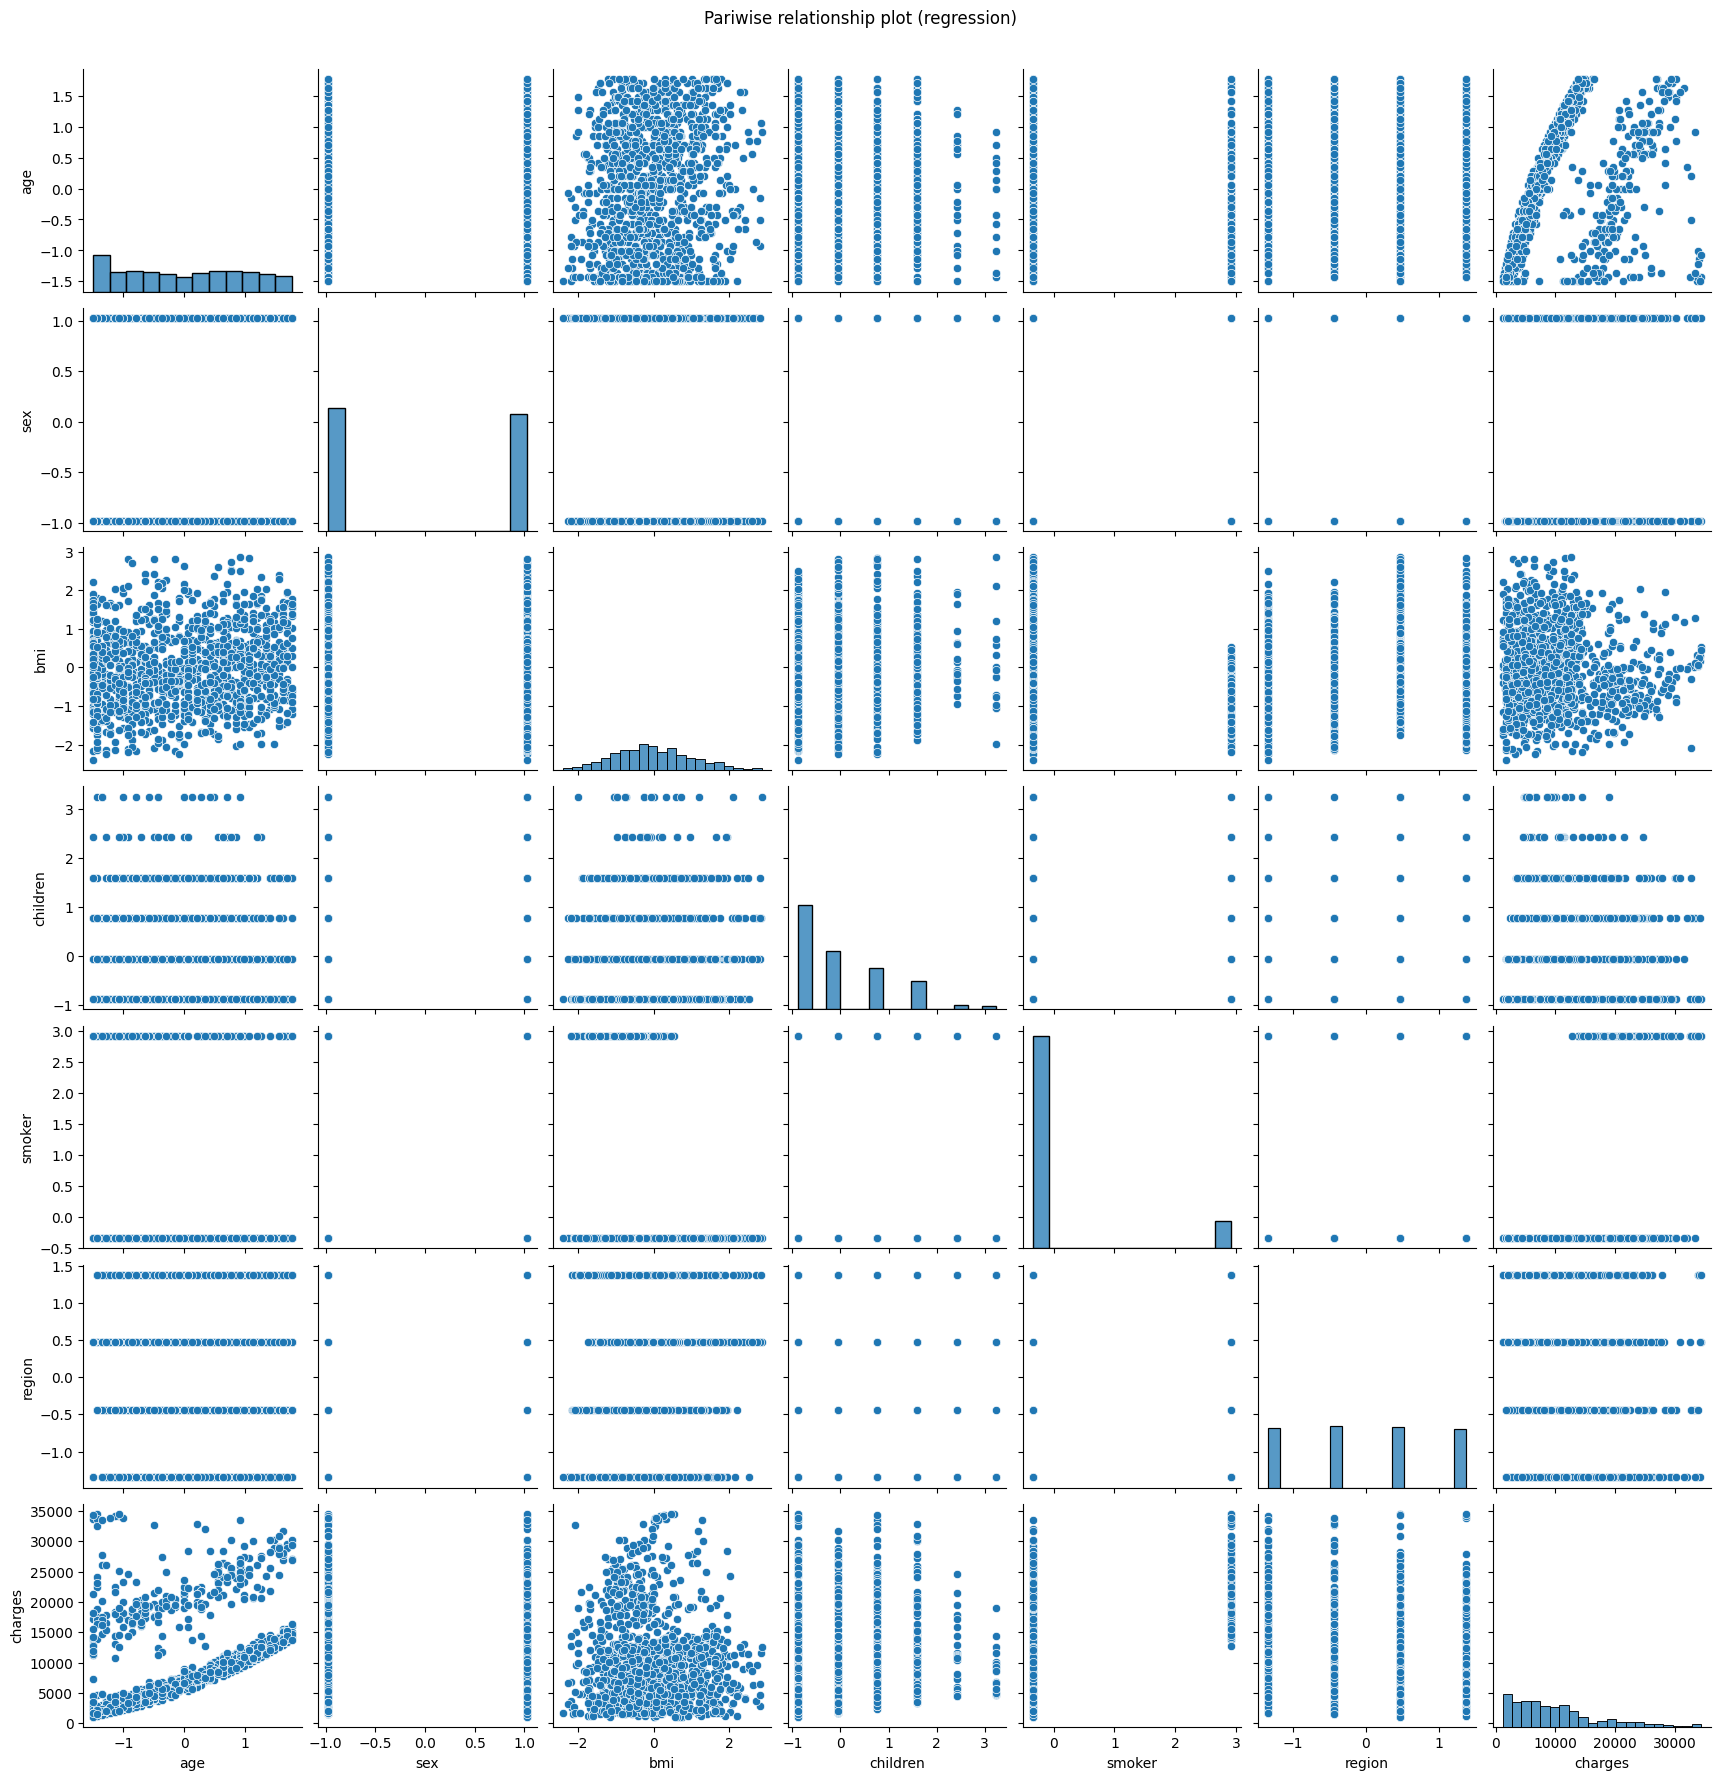

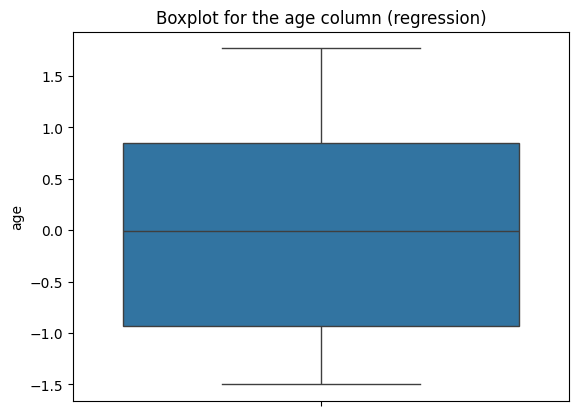

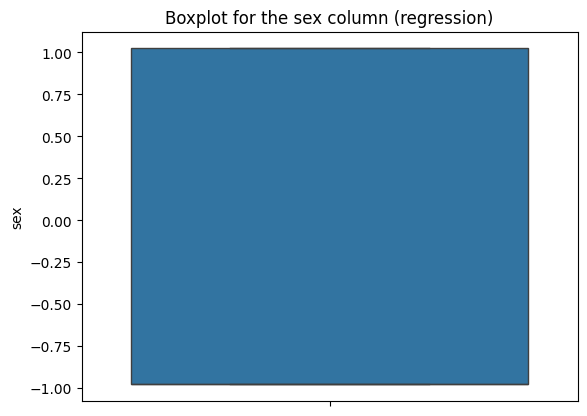

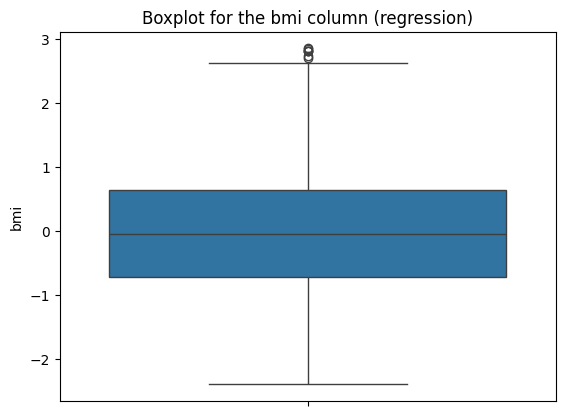

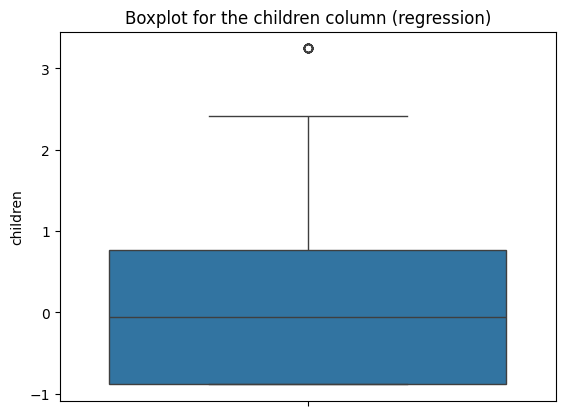

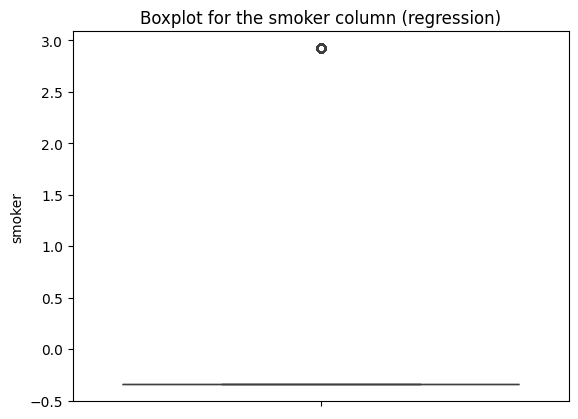

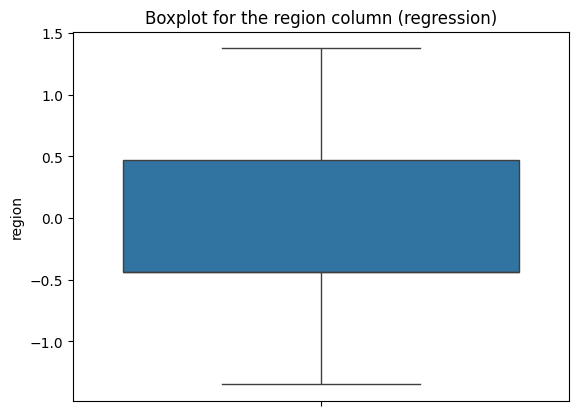

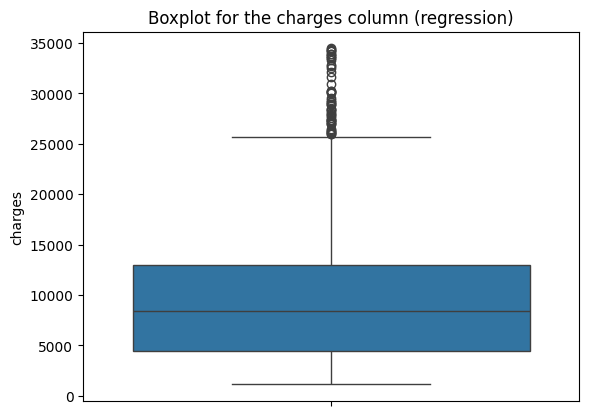

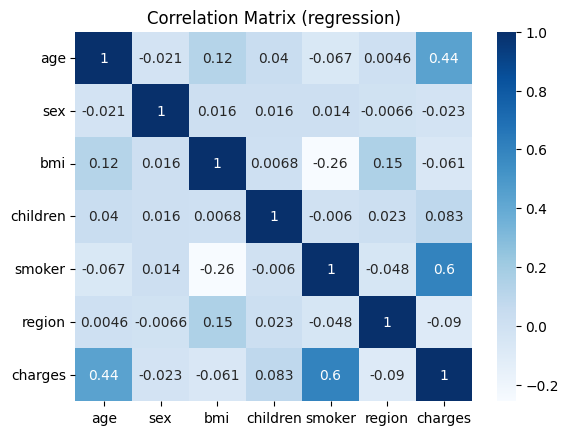

In [32]:
# Testing EDA (Regression)

eda_visualization(preprocessed_df_reg, 'regression')

### 4.2 EDA Classification

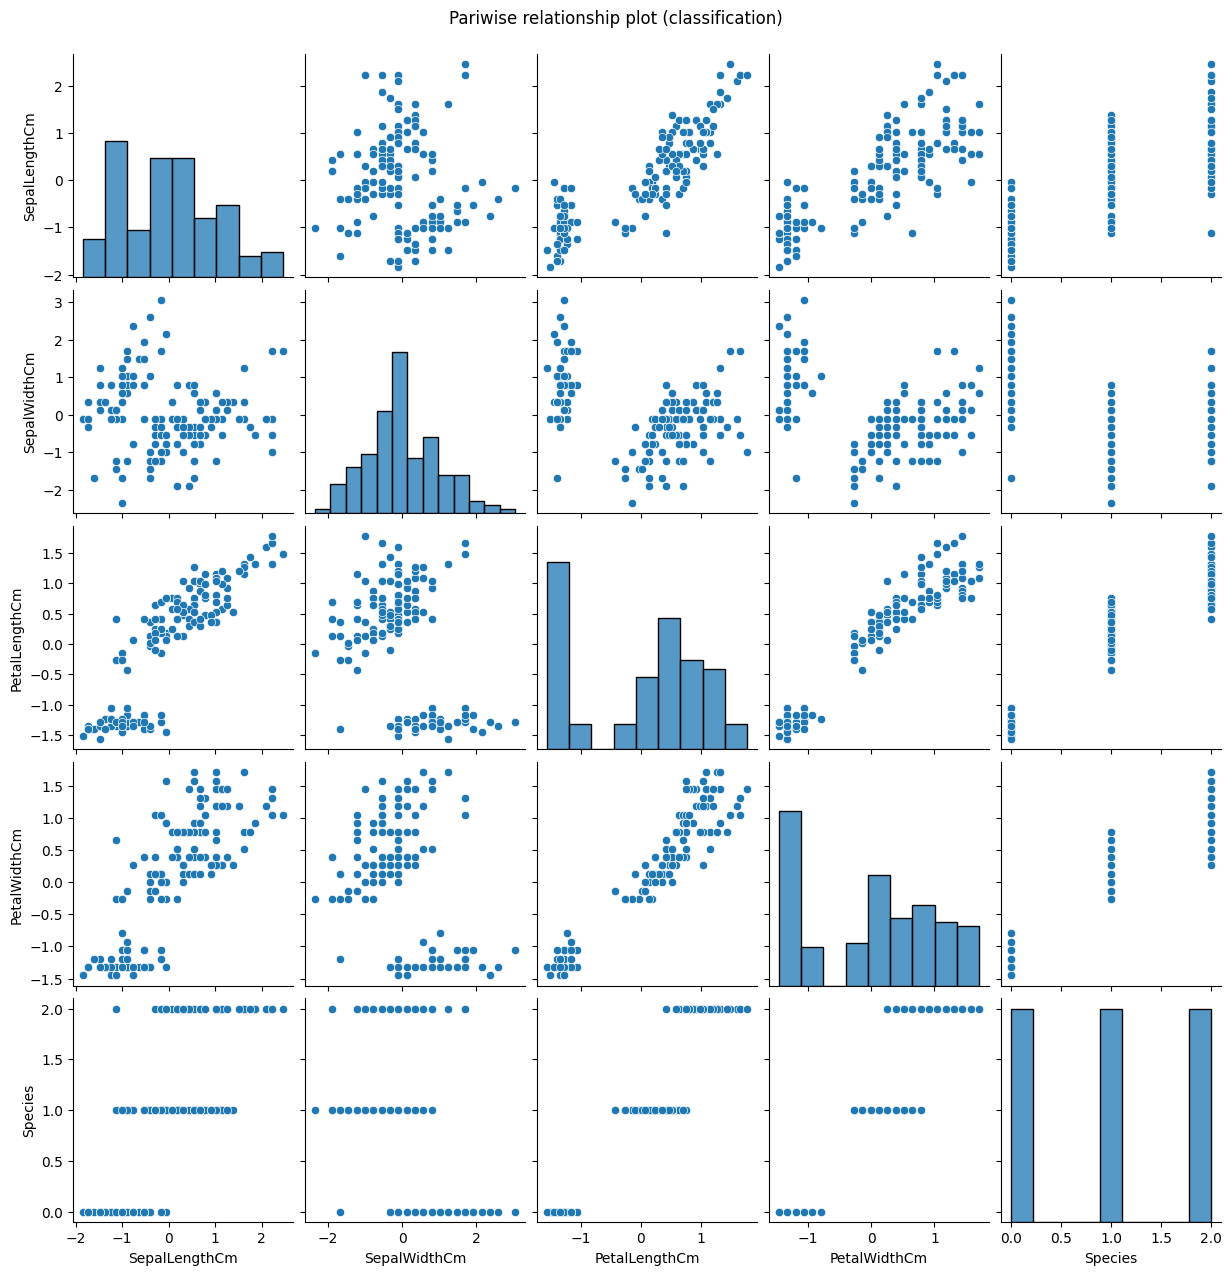

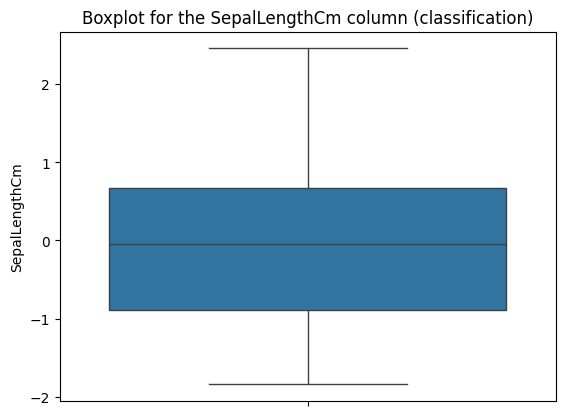

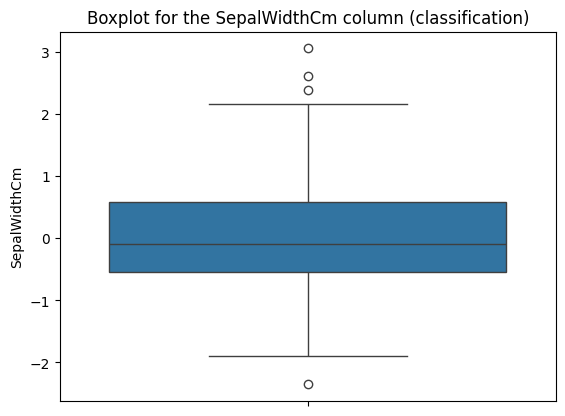

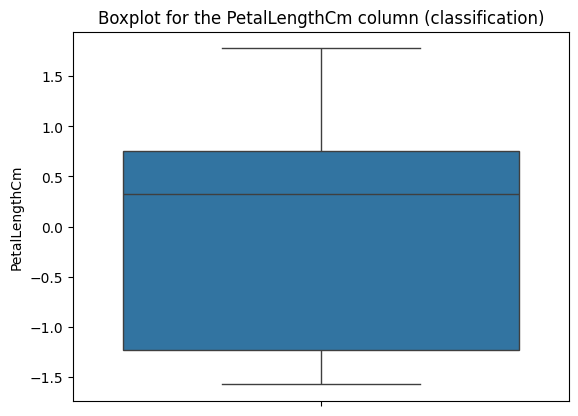

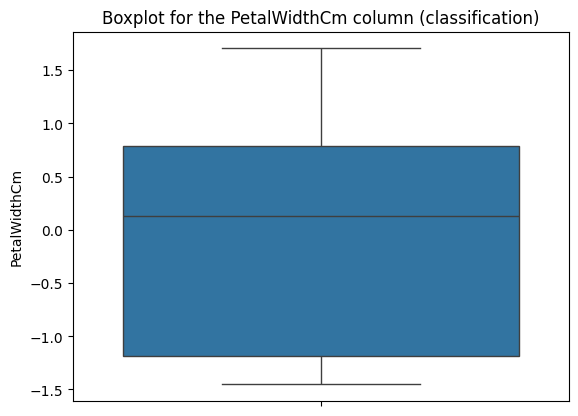

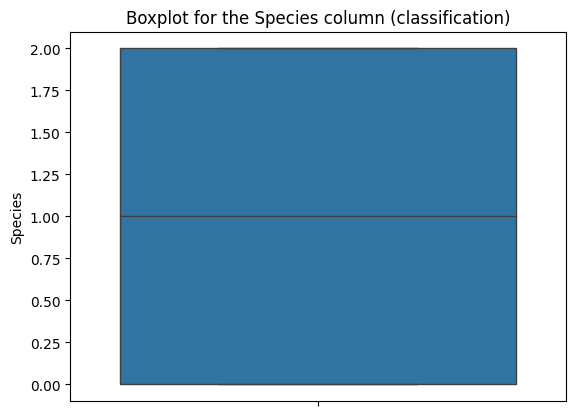

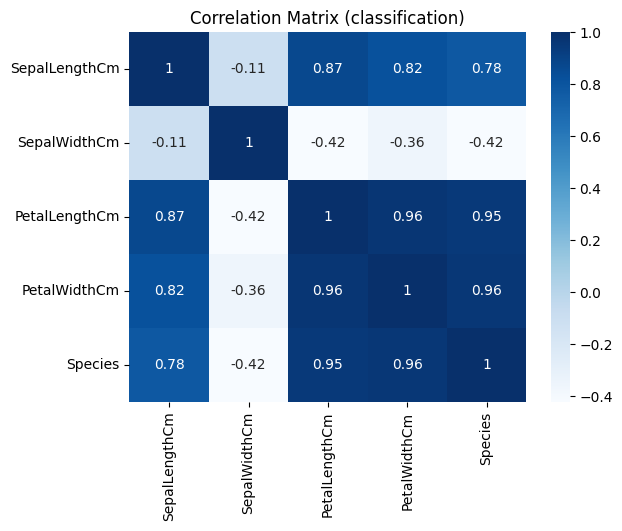

In [33]:
# Testing EDA (Classification)

eda_visualization(preprocessed_df_clf, 'classification')

### 4.3 EDA Clustering

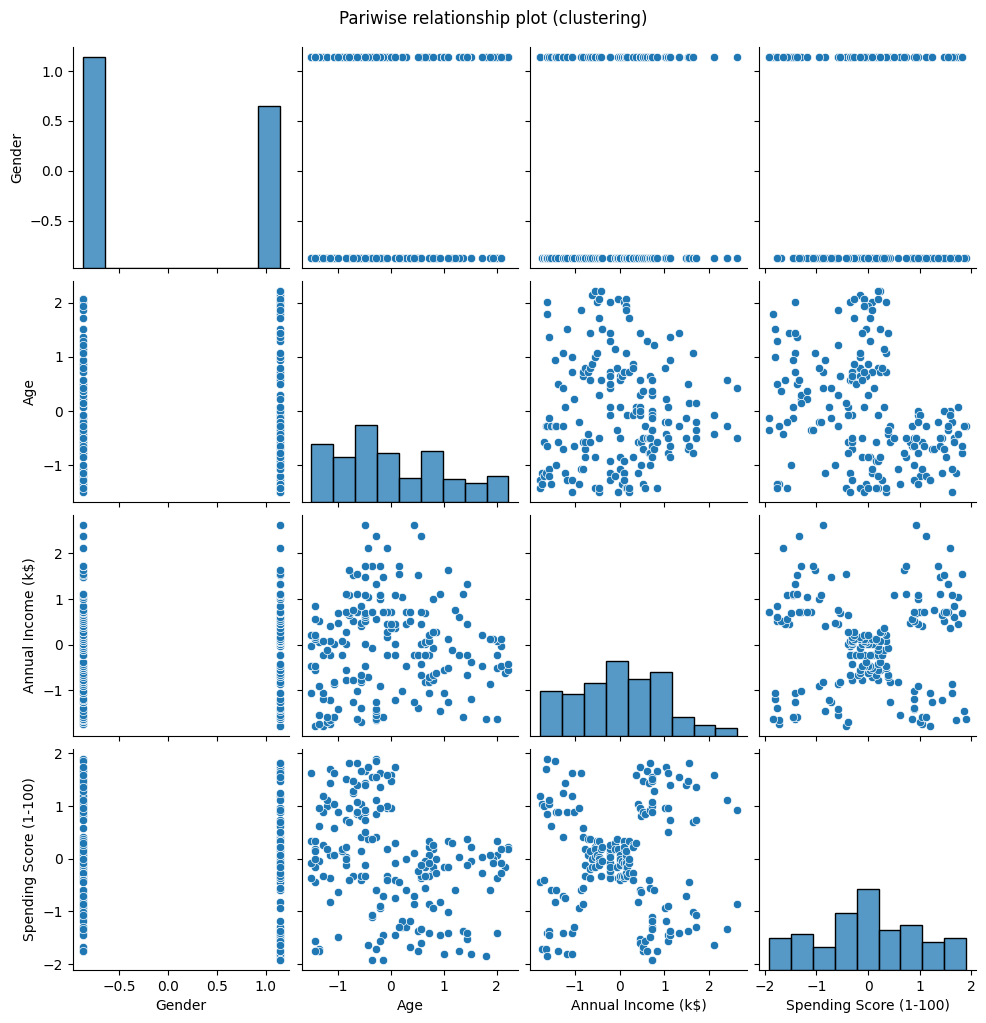

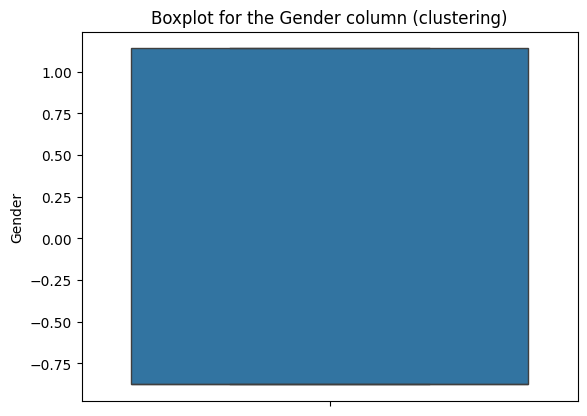

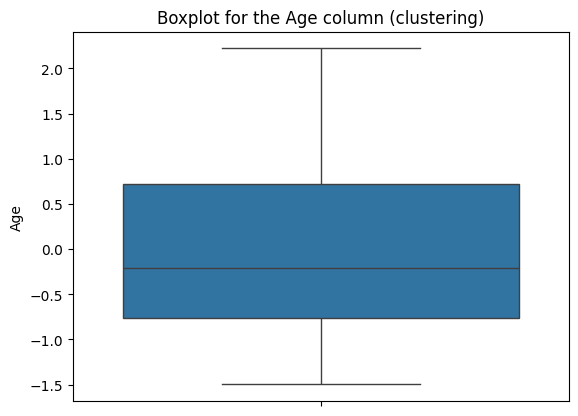

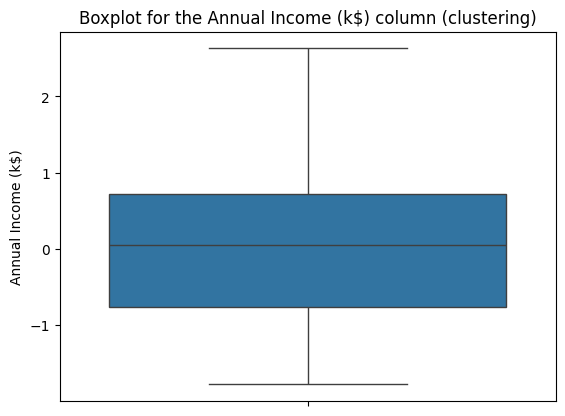

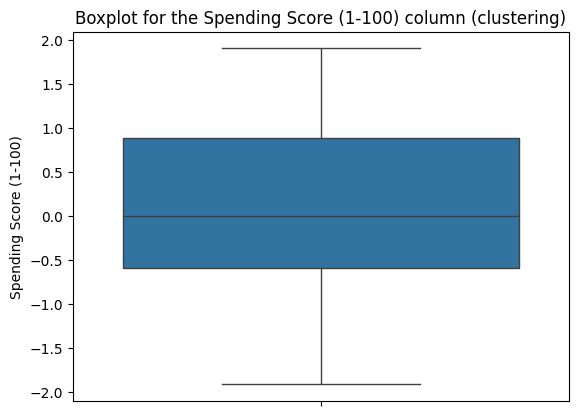

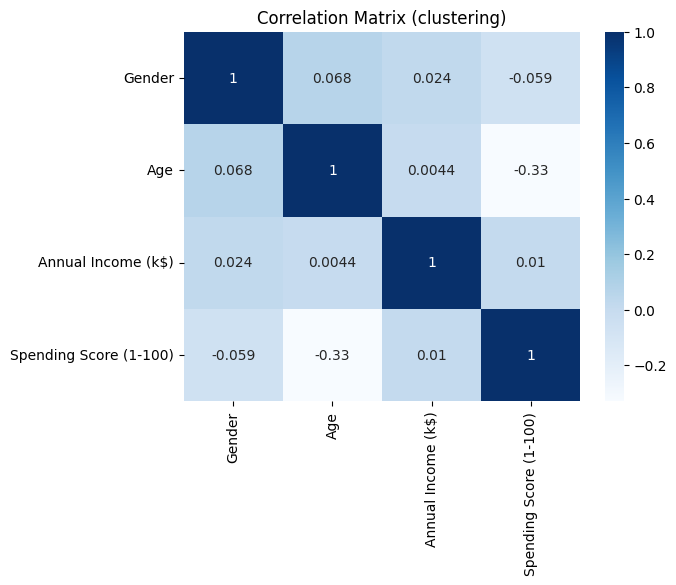

In [34]:
# Testing EDA (Clustering)

eda_visualization(preprocessed_df_cls, 'clustering')

## **5. Evaluation**

In [35]:
def evaluate(data, task_type):

    # Assign data into specified cases
    data_dict = create_data_dict(data, task_type)

    # Model and necessary variable(s)
    model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput = model_and_variables(data_dict, task_type)

    # For evaluation
    metrics_names, eval_metrics = evaluation_metrics(task_type)

    # Setting the min-max value
    minmax_val = "min" if reference_metric in ["Mean Squared Error (MSE)",
                                                "Root Mean Squared Error (RMSE)",
                                                "Mean Absolute Error (MAE)",
                                                "Mean Absolute Percentage Error (MAPE)",
                                                "Davies-Bouldin Index",
                                                ] else "max"

    # Getting hyperparameter bounds and names
    paras_bounds, paras_bounds_names = hyperparameters_bounds(model, random_state=42)

    epoch = 200
    pop_size = 50

    # Assigning Simulated Annealing Optimizer
    optimizer = SA.OriginalSA(epoch=epoch, pop_size=pop_size, temp_init=100, step_size=0.1)

    # List for containing evaluation values
    metaopt_name = []
    metaopt_object = []
    ml_models = []
    best_metrics = []
    time_taken = []

    #  Defining the problem class
    problem = OptimizedProblem(bounds=paras_bounds,
                                minmax=minmax_val,
                                data=data_dict,
                                model=model,
                                task_type=task_type,
                                paras_bounds_names=paras_bounds_names,
                                n_classes = n_classes,
                                is_multioutput = is_multioutput,
                                )

    # Time monitoring and optimization process
    start = time.perf_counter()
    optimizer.solve(problem)
    end = time.perf_counter() - start

    best_paras = optimizer.problem.decode_solution(optimizer.g_best.solution)

    best_paras_decoded = decode_best_paras(model, best_paras, n_classes, is_multioutput)
    
    best_ml_model, best_metrics_opt = optimized_fit_predict(model = model,
                                                            paras = best_paras_decoded,
                                                            data = data_dict,
                                                            task_type = task_type,
                                                            eval_metrics = eval_metrics,
                                                            n_classes = n_classes,
                                                            is_multioutput = is_multioutput,
                                                            n_obsv = n_obsv,
                                                            n_predictors = n_predictors,
                                                            )

    metaopt_name.append(optimizer.__class__.__name__)
    metaopt_object.append(optimizer)
    ml_models.append(best_ml_model)
    best_metrics.append(best_metrics_opt)
    time_taken.append(end)

    print(f"Best agent: {optimizer.g_best}")
    print(f"Best solution: {optimizer.g_best.solution}")
    print(f"Best {reference_metric}: {optimizer.g_best.target.fitness}")
    print(f"Best parameters: {best_paras}\n")        

    # Final result
    result_df = pd.DataFrame ({
        "Metaheuristic Optimizer (Name)" : metaopt_name,
        "Metaheuristic Optimizer (Object)" : metaopt_object,
        "Machine Learning Model (object)" : ml_models,
        **{metric: values for metric, values in zip(metrics_names, zip(*best_metrics))},
        "Time taken (s)" : time_taken,
    })

    # Save the trained model
    ascending = None
    if minmax_val == "max":
        ascending = False
    else:
        ascending = True

    best_ml_model = result_df.sort_values(by=reference_metric, ascending=ascending).iloc[0,2]
    joblib.dump(best_ml_model, f'Best_{best_ml_model.__class__.__name__}.pkl')

    return result_df, best_ml_model, data_dict

In [47]:
# Testing evaluation block

for task_type, preprocessed_df in zip(task_type_list, preprocessed_df_list):

    result_df, best_ml_model, data_dict = evaluate(data=preprocessed_df, task_type=task_type)

    # print(f"\nResult df:\n{result_df}\n")
    # print(f"Best ml model:\n{best_ml_model}\n")
    # print(f"Data Dictionary:\n{data_dict}\n")

    if task_type == 'regression':
        result_df_reg, best_ml_model_reg, data_dict_reg = result_df, best_ml_model, data_dict
        
    elif task_type == 'classification':
        result_df_clf, best_ml_model_clf, data_dict_clf = result_df, best_ml_model, data_dict

    elif task_type == 'clustering':
        result_df_cls, best_ml_model_cls, data_dict_cls = result_df, best_ml_model, data_dict

result_df_list = [result_df_reg, result_df_clf, result_df_cls]
best_ml_model_list = [best_ml_model_reg, best_ml_model_clf, best_ml_model_cls]
data_dict_list = [data_dict_reg, data_dict_clf, data_dict_cls]

2024/12/04 03:51:43 PM, INFO, mealpy.physics_based.SA.OriginalSA: Solving single objective optimization problem.
2024/12/04 03:51:49 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 1, Current best: 19759691.901457485, Global best: 19759691.901457485, Runtime: 0.13178 seconds
2024/12/04 03:51:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 2, Current best: 19759691.901457485, Global best: 19759691.901457485, Runtime: 0.12311 seconds
2024/12/04 03:51:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 3, Current best: 19759691.901457485, Global best: 19759691.901457485, Runtime: 0.13858 seconds
2024/12/04 03:51:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 4, Current best: 19759691.901457485, Global best: 19759691.901457485, Runtime: 0.11707 seconds
2024/12/04 03:51:50 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 5, Current best: 19759691.901457485, Global best: 19759691.90145748

Best agent: id: 1057, target: Objectives: [19759691.90145748], Fitness: 19759691.90145748, solution: [75.65134183  3.01515937  3.02934574 29.96841207 82.06947852 -0.19760377
  1.10766675 98.03267574 61.52468382 -0.25815755 -0.46760755  3.51022471
  0.42697716  1.49344511 92.42470312 -0.11234467]
Best solution: [75.65134183  3.01515937  3.02934574 29.96841207 82.06947852 -0.19760377
  1.10766675 98.03267574 61.52468382 -0.25815755 -0.46760755  3.51022471
  0.42697716  1.49344511 92.42470312 -0.11234467]
Best Mean Squared Error (MSE): 19759691.90145748
Best parameters: {'n_estimators_paras': 76, 'criterion_paras': 'squared_error', 'max_depth_paras': 100, 'min_samples_split_paras': 30, 'min_samples_leaf_paras': 82, 'min_weight_fraction_leaf_paras': 0.0, 'max_features_paras': 'none', 'max_leaf_nodes_paras': 98, 'min_impurity_decrease_paras': 61.524683817617905, 'bootstrap_paras': False, 'oob_score_paras': False, 'n_jobs_paras': 100, 'random_state_paras': 'none', 'warm_start_paras': True, '

2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 1, Current best: 0.16666666666666666, Global best: 0.16666666666666666, Runtime: 0.01534 seconds
2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 2, Current best: 0.16666666666666666, Global best: 0.16666666666666666, Runtime: 0.01328 seconds
2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 3, Current best: 0.16666666666666666, Global best: 0.16666666666666666, Runtime: 0.01355 seconds
2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 4, Current best: 0.16666666666666666, Global best: 0.16666666666666666, Runtime: 0.01552 seconds
2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 5, Current best: 0.16666666666666666, Global best: 0.16666666666666666, Runtime: 0.01313 seconds
2024/12/04 03:52:16 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Proble

Best agent: id: 2115, target: Objectives: [0.16666667], Fitness: 0.16666666666666666, solution: [15.          2.          2.          5.         54.          0.26259319
  5.         41.         80.85173502  1.          0.          0.
  1.          1.          0.         31.25034773  1.          1.        ]
Best solution: [15.          2.          2.          5.         54.          0.26259319
  5.         41.         80.85173502  1.          0.          0.
  1.          1.          0.         31.25034773  1.          1.        ]
Best F1-Score: 0.16666666666666666
Best parameters: {'n_estimators_paras': 15, 'criterion_paras': 'log_loss', 'max_depth_paras': 50, 'min_samples_split_paras': 5, 'min_samples_leaf_paras': 54, 'min_weight_fraction_leaf_paras': 0.2625931858446496, 'max_features_paras': 10, 'max_leaf_nodes_paras': 41, 'min_impurity_decrease_paras': 80.85173501808806, 'bootstrap_paras': True, 'oob_score_paras': False, 'n_jobs_paras': 'none', 'random_state_paras': 42, 'warm_start_p

2024/12/04 03:52:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: Solving single objective optimization problem.
2024/12/04 03:52:27 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 1, Current best: 0.43553630583090547, Global best: 0.43553630583090547, Runtime: 0.18304 seconds
2024/12/04 03:52:27 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 2, Current best: 0.43553630583090547, Global best: 0.43553630583090547, Runtime: 0.19195 seconds
2024/12/04 03:52:28 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 3, Current best: 0.43553630583090547, Global best: 0.43553630583090547, Runtime: 0.18766 seconds
2024/12/04 03:52:28 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 4, Current best: 0.43553630583090547, Global best: 0.43553630583090547, Runtime: 0.18453 seconds
2024/12/04 03:52:28 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 5, Current best: 0.4357207313225655, Global best: 0.4357207

Best agent: id: 3173, target: Objectives: [0.43572073], Fitness: 0.4357207313225655, solution: [  1.19599591  11.26378839 444.23123691   3.86600102]
Best solution: [  1.19599591  11.26378839 444.23123691   3.86600102]
Best Silhouette Score: 0.4357207313225655
Best parameters: {'algorithm_paras': 'lloyd', 'n_clusters_paras': 11, 'max_iter_paras': 444, 'n_init_paras': 10}



In [48]:
# Regression Optimization result
result_df_list[0]

,Metaheuristic Optimizer (Name),Metaheuristic Optimizer (Object),Machine Learning Model (object),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Mean Absolute Percentage Error (MAPE),R-Squared,Adjusted R-Squared,Explained Variance Score,Time taken (s)
0,OriginalSA,"OriginalSA(epoch=200, temp_init=100.0, step_si...",(DecisionTreeRegressor(ccp_alpha=92.4247031219...,1.975969e+07,4445.187499,2863.457632,0.347732,0.586728,0.57604,0.588517,29.244848


In [49]:
# Classification Optimization result
result_df_list[1]

,Metaheuristic Optimizer (Name),Metaheuristic Optimizer (Object),Machine Learning Model (object),Accuracy,Precision,Recall,F1-Score,Time taken (s)
0,OriginalSA,"OriginalSA(epoch=200, temp_init=100.0, step_si...",(DecisionTreeClassifier(ccp_alpha=31.250347732...,0.333333,0.333333,0.333333,0.166667,7.045953


In [50]:
# Clustering Optimization result
result_df_list[2]

,Metaheuristic Optimizer (Name),Metaheuristic Optimizer (Object),Machine Learning Model (object),Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Time taken (s)
0,OriginalSA,"OriginalSA(epoch=200, temp_init=100.0, step_si...","KMeans(max_iter=444, n_clusters=11, n_init=10)",0.432351,0.815072,93.44698,43.832466


In [51]:
best_kmeans = joblib.load(open('Best_KMeans.pkl', 'rb'))
best_kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 444,
 'n_clusters': 11,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

### 5.1 Evaluation Metrics

In [36]:
# Deploy purps

def evaluation_metrics(task_type):
    if task_type == 'regression':
        """ Regression """

        regression_metrics_names = ["Mean Squared Error (MSE)",
                                    "Root Mean Squared Error (RMSE)",
                                    "Mean Absolute Error (MAE)",
                                    "Mean Absolute Percentage Error (MAPE)",
                                    "R-Squared",
                                    "Adjusted R-Squared",
                                    "Explained Variance Score",
                                    ]

        def regression_evaluation_metrics(y_test, y_pred, n, p):
            # Calculating metrics
            MSE = mean_squared_error(y_test, y_pred)
            RMSE = np.sqrt(MSE)
            MAE = mean_absolute_error(y_test, y_pred)
            MAPE = mean_absolute_percentage_error(y_test, y_pred)
            R2 = r2_score(y_test, y_pred)
            
            # Adjusted R-Squared
            adj_r2 = 1 - (1 - R2) * ((n - 1) / (n - p - 1))
            
            # Explained Variance Score
            expl_var_score = explained_variance_score(y_test, y_pred)

            # Create a list of metric values in the same order as the dictionary keys
            metrics_values = [MSE, RMSE, MAE, MAPE, R2, adj_r2, expl_var_score]

            # Return all metrics as a tuple
            return metrics_values

        return [regression_metrics_names, regression_evaluation_metrics]

    elif task_type == 'classification':
        """ Classification """

        classification_metrics_names = ["Accuracy",
                            "Precision",
                            "Recall",
                            "F1-Score",
                            ]

        def classification_evaluation_metrics(y_test, y_pred, n_classes):
            # Average method for certain metrics
            if n_classes > 2:
                average = 'macro'
                
                precision = precision_score(y_test, y_pred, average=average, zero_division=np.nan)
                recall = recall_score(y_test, y_pred, average=average)
                f1_sc = f1_score(y_test, y_pred, average=average)

            else: # if n_classes == 2:
                average = 'binary'
                
                precision = precision_score(y_test, y_pred, average=average, zero_division=np.nan)
                recall = recall_score(y_test, y_pred, average=average)
                f1_sc = f1_score(y_test, y_pred, average=average)

            # accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Create a list of metric values in the same order as the dictionary keys
            metrics_values = [accuracy, precision, recall, f1_sc]

            return metrics_values

        return [classification_metrics_names, classification_evaluation_metrics]

    elif task_type == 'clustering':
        """ Clustering """

        clustering_metrics_names = ["Silhouette Score",
                                    "Davies-Bouldin Index",
                                    "Calinski-Harabasz Index",
                                    ]

        def clustering_evaluation_metrics(df, labels):
            # Silhouette score
            silhouette = silhouette_score(df, labels)       # Closer to 1 values suggest better-defined clusters.
            db_index = davies_bouldin_score(df, labels)     # A lower score is preferable
            ch_index = calinski_harabasz_score(df, labels)  # Higher is better

            # Create a list of metric values in the same order as the dictionary keys
            metrics_values = [silhouette, db_index, ch_index]

            return metrics_values

        return [clustering_metrics_names, clustering_evaluation_metrics]
    
    else:
        raise ValueError(f"Unsupported task type: {task_type}")


### 5.2 Dependecies Handling

In [37]:
def dependencies_handling(all_decoded_paras,
                            self=None,
                            ml_model=None,
                            n_classes=None,
                            is_multioutput=None
                            ):
    
    # Model Name
    if self is None:
        ml_model_name = ml_model.__name__
        default_params_values = ml_model().get_params()
    else:
        ml_model_name = self.model.__name__
        default_params_values = self.model().get_params()
        n_classes = self.n_classes
        is_multioutput = self.is_multioutput

    paras_names = list(all_decoded_paras.keys())

    if ml_model_name == 'RandomForestRegressor':

        required_keys = {"bootstrap", "max_samples", "oob_score"}

        if all(key in paras_names for key in required_keys):

            # Dep2: Handle the interdependency between bootstrap and max_samples
            if not all_decoded_paras["bootstrap"]:
                all_decoded_paras["max_samples"] = None  # Ensure max_samples is None if bootstrap=False
                all_decoded_paras["oob_score"] = False
        
        else:
            for required_key in required_keys:
                all_decoded_paras[required_key] = default_params_values[required_key]

    elif ml_model_name == 'RandomForestClassifier':

        required_keys = {"bootstrap", "max_samples", "oob_score", "class_weight", "warm_start", "monotonic_cst"}
        
        if all(key in paras_names for key in required_keys):
                
            # Dep2: Handle the interdependency between bootstrap and max_samples
            if not all_decoded_paras["bootstrap"]:
                all_decoded_paras["max_samples"] = None     # Ensure max_samples is None if bootstrap=False
                all_decoded_paras["oob_score"] = False

            # Dep3: Handle monotonic constraint
            if n_classes > 2 or is_multioutput:
                all_decoded_paras["monotonic_cst"] = None   # set monotonic_cst to None for multiclass classification or multi-output
            
            # Dep4: class_weight & warm_start
            if all_decoded_paras["class_weight"] in ('balanced', 'balanced_subsample'):
                all_decoded_paras["warm_start"] = False
        
        else:
            for required_key in required_keys:
                all_decoded_paras[required_key] = default_params_values[required_key]

    return all_decoded_paras

dependency_rules = {
    "RandomForestRegressor": {
        "required_keys": {"bootstrap", "max_samples", "oob_score"},
        "handler": lambda params, defaults, **kwargs: {
            "max_samples": None if not params.get("bootstrap", False) else params.get("max_samples", defaults["max_samples"]),
            "oob_score": False if not params.get("bootstrap", False) else params.get("oob_score", defaults["oob_score"])
        }
    },
    "RandomForestClassifier": {
        "required_keys": {"bootstrap", "max_samples", "oob_score", "class_weight", "warm_start", "monotonic_cst"},
        "handler": lambda params, defaults, n_classes, is_multioutput: {
            "max_samples": None if not params.get("bootstrap", False) else params.get("max_samples", defaults["max_samples"]),
            "oob_score": False if not params.get("bootstrap", False) else params.get("oob_score", defaults["oob_score"]),
            "monotonic_cst": None if n_classes > 2 or is_multioutput else params.get("monotonic_cst", defaults["monotonic_cst"]),
            "warm_start": False if params.get("class_weight") in ("balanced", "balanced_subsample") else params.get("warm_start", defaults["warm_start"])
        }
    }
}



### 5.3 Data Dictionary

In [38]:
def create_data_dict(data, task_type):

    if task_type in ('regression', 'classification'):
        data = {
            "X_train": data[0],
            "X_test": data[1],
            "y_train": data[2],
            "y_test": data[3], 
        }
        
    elif task_type == 'clustering':
        data = {"X" : data}

    return data

In [39]:
# Testing data_dictionary

for task_type, preprocessed_df in zip(task_type_list, preprocessed_df_list):

    if task_type == 'regression':
        df_reg_dict = create_data_dict(preprocessed_df, task_type)

        print(f"Data dictionary for {task_type} data:\n", df_reg_dict,'\n')

    elif task_type == 'classification':
        df_clf_dict = create_data_dict(preprocessed_df, task_type)

        print(f"Data dictionary for {task_type} data:\n", df_clf_dict,'\n')

    elif task_type == 'clustering':
        df_cls_dict = create_data_dict(preprocessed_df, task_type)

        print(f"Data dictionary for {task_type} data:\n", df_cls_dict,'\n')

data_dict_list = [df_reg_dict, df_clf_dict, df_cls_dict]

Data dictionary for regression data:
 {'X_train':           age       sex       bmi  children    smoker    region
0    0.347385  1.023333 -0.447469  0.766327 -0.342193  1.374625
1    1.058097  1.023333  1.629846 -0.059748 -0.342193  1.374625
2    1.768810 -0.977199  1.536196  1.592401 -0.342193  0.467087
3    0.631670  1.023333  0.029292  0.766327 -0.342193  1.374625
4   -0.079043  1.023333 -1.516776  1.592401 -0.342193  0.467087
..        ...       ...       ...       ...       ...       ...
949  1.200240 -0.977199  2.023174 -0.885822 -0.342193  0.467087
950  0.205242  1.023333  1.217788  0.766327 -0.342193  0.467087
951  1.129168 -0.977199  0.080373 -0.885822 -0.342193  1.374625
952 -0.292256  1.023333 -0.498551 -0.059748 -0.342193  1.374625
953  0.134171 -0.977199 -0.336793 -0.059748 -0.342193  0.467087

[954 rows x 6 columns], 'X_test':           age       sex       bmi  children    smoker    region
0   -0.150114  1.023333  2.809829  1.592401 -0.342193  0.467087
1   -1.074040  1.02

### 5.4 Problem Class

In [40]:
class OptimizedProblem(Problem):
    def __init__(
                    self,
                    bounds=None,
                    minmax="max",
                    data=None,
                    model=None,
                    task_type=None,
                    paras_bounds_names=None,
                    n_classes=None,
                    is_multioutput=None,
                    **kwargs
                ):
        self.data = data       
        self.model = model
        self.task_type = task_type
        self.paras_bounds_names = paras_bounds_names
        self.n_classes = n_classes
        self.is_multioutput = is_multioutput

        self.all_decoded_paras = {}
        self.encoders = {}

        super().__init__(bounds, minmax, **kwargs)

    def obj_func(self, x):
        task_type = self.task_type
        all_decoded_paras = self.all_decoded_paras
        original_paras = {}

        x_decoded = self.decode_solution(x)

        # print(self.paras_bounds_names)
        for paras_name in self.paras_bounds_names:

            original_paras[paras_name] = x_decoded[paras_name]

            all_decoded_paras[paras_name[:-6]] = None if original_paras[paras_name] == 'none' else original_paras[paras_name]

        # Decoded paras (dict) after handling dependecies
        all_decoded_paras = dependencies_handling(all_decoded_paras, self=self)

        # Defining the model and assigning hyperparameters
        ml_model = self.model(**all_decoded_paras)  

        # Supervised tasks
        if task_type in ('regression', 'classification'):

            # Fit the model
            ml_model.fit(self.data["X_train"], self.data["y_train"])

            # Make the predictions
            y_predict = ml_model.predict(self.data["X_test"])

            # MSE for Regression
            if task_type == 'regression':
                return mean_squared_error(self.data["y_test"], y_predict)

            # F1-Score for Classification
            elif task_type == 'classification':
                return f1_score(self.data["y_test"], y_predict, average='macro')

        # Unsupervised tasks (Clustering)
        elif task_type == 'clustering':
            
            # Fit the model
            ml_model.fit_predict(self.data["X"])
            
            # Make the predictions
            labels = ml_model.fit_predict(self.data["X"])
            
            # Silhouette Score for Clustering
            return silhouette_score(self.data["X"], labels)

### 5.5 Model and Variables

In [41]:
def model_and_variables(data, task_type):
    model = None
    reference_metric = None
    n_obsv = None
    n_predictors = None
    n_classes = None
    is_multioutput = None

    if task_type == 'regression':
        model = RandomForestRegressor
        reference_metric = "Mean Squared Error (MSE)"

        n_obsv = len(data["y_test"])  # Number of observations
        n_predictors = data["X_test"].shape[1]  # Number of predictors (features)

    elif task_type == 'classification':
        n_classes = len(np.unique(data["y_train"]))
        is_multioutput = len(data["y_train"].shape) > 1 and data["y_train"].shape[1] > 1 if data["y_train"] is not None else False

        model = RandomForestClassifier
        reference_metric = "F1-Score"

    elif task_type == 'clustering':
        model = KMeans
        reference_metric = "Silhouette Score"

    return model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput

In [42]:
# Testing Model and Variable

for task_type, data_dict in zip(task_type_list, data_dict_list):

    model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput = model_and_variables(data_dict, task_type)

    print(f"Current task type: {task_type}")
    print(f"Model name: {model.__name__}")
    print(f"Reference metric: {reference_metric}")

    print(f"Number of observation: {n_obsv}")
    print(f"Number of predictors: {n_predictors}")

    print(f"Number of classes: {n_classes}")
    print(f"Is it multilabel/multioutput? : {is_multioutput}\n")

    # if task_type == 'regression':
    #     print(f"Number of observation: {n_obsv}")
    #     print(f"Number of predictors: {n_predictors}")

    # elif task_type == 'classification':
    #     print(f"Number of classes: {n_classes}")
    #     print(f"Is it multilabel/multioutput? : {is_multioutput}")

    if task_type == 'regression':
        model_var_reg = [model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput]

    elif task_type == 'classification':
        model_var_clf = [model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput]

    elif task_type == 'clustering':
        model_var_cls = [model, reference_metric, n_obsv, n_predictors, n_classes, is_multioutput]

model_var_list = [model_var_reg, model_var_clf, model_var_cls]

Current task type: regression
Model name: RandomForestRegressor
Reference metric: Mean Squared Error (MSE)
Number of observation: 239
Number of predictors: 6
Number of classes: None
Is it multilabel/multioutput? : None

Current task type: classification
Model name: RandomForestClassifier
Reference metric: F1-Score
Number of observation: None
Number of predictors: None
Number of classes: 3
Is it multilabel/multioutput? : False

Current task type: clustering
Model name: KMeans
Reference metric: Silhouette Score
Number of observation: None
Number of predictors: None
Number of classes: None
Is it multilabel/multioutput? : None



### 5.6 Hyperparameter Bounds

In [43]:
def hyperparameters_bounds(model, random_state=42):
    # Model Name
    model_name = model.__name__

    if model_name == 'RandomForestRegressor':
        paras_bounds = [
            IntegerVar(lb=1, ub=100, name="n_estimators_paras"),
            StringVar(valid_sets=('squared_error', 'absolute_error', 'friedman_mse', 'poisson'), name="criterion_paras"),
            MixedSetVar(valid_sets=('none', 10, 50, 100), name="max_depth_paras"),
            IntegerVar(lb=2, ub=100, name="min_samples_split_paras"),                     # int in the range [2, inf) or a float in the range (0.0, 1.0]
            IntegerVar(lb=2, ub=100, name="min_samples_leaf_paras"),                      # int in the range [1, inf) or a float in the range (0.0, 1.0)
            FloatVar(lb=0., ub=0.5, name="min_weight_fraction_leaf_paras"),             # float in the range [0.0, 0.5]
            MixedSetVar(valid_sets=('none', 'sqrt', 'log2', 1, 5, 10, 50, 100), name="max_features_paras"),
            IntegerVar(lb=2, ub=100, name="max_leaf_nodes_paras"),                      # int in the range [2, inf)
            FloatVar(lb=1., ub=100., name="min_impurity_decrease_paras"),
            BoolVar(n_vars=1, name="bootstrap_paras"),                                  # `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`
            BoolVar(n_vars=1, name="oob_score_paras"),                                  # Only available if bootstrap=True
            MixedSetVar(valid_sets=('none', 10, 50, 100), name="n_jobs_paras"),
            MixedSetVar(valid_sets=('none', random_state), name="random_state_paras"),  # Dependant towards bootstrap=True
            BoolVar(n_vars=1, name="warm_start_paras"),
            FloatVar(lb=0., ub=100., name="ccp_alpha_paras"),
            MixedSetVar(valid_sets=('none', 5, 10, 15), name="max_samples_paras"),      # `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`

            # MixedSetVar(valid_sets=('none', -1, 0, -1), name="monotonic_cst_paras"),    # unspported when n_outputs_ > 1 (multioutput regression) or data has missing (NA) values
            # IntegerVar(lb=0, ub=3, name="verbose_paras"),                             # Irrelevant
        ]

    elif model_name == 'RandomForestClassifier':
        paras_bounds = [
            IntegerVar(lb=1, ub=100, name="n_estimators_paras"),
            StringVar(valid_sets=('gini', 'entropy', 'log_loss'), name="criterion_paras"),
            MixedSetVar(valid_sets=('none', 10, 50, 100), name="max_depth_paras"),
            IntegerVar(lb=2, ub=100, name="min_samples_split_paras"),                     # int in the range [2, inf) or a float in the range (0.0, 1.0]
            IntegerVar(lb=2, ub=100, name="min_samples_leaf_paras"),                      # int in the range [1, inf) or a float in the range (0.0, 1.0)
            FloatVar(lb=0., ub=0.5, name="min_weight_fraction_leaf_paras"),             # float in the range [0.0, 0.5]
            MixedSetVar(valid_sets=('none', 'sqrt', 'log2', 1, 5, 10, 50, 100), name="max_features_paras"),
            IntegerVar(lb=2, ub=100, name="max_leaf_nodes_paras"),                      # int in the range [2, inf)
            FloatVar(lb=1., ub=100., name="min_impurity_decrease_paras"),
            BoolVar(n_vars=1, name="bootstrap_paras"),                                  # `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`
            BoolVar(n_vars=1, name="oob_score_paras"),                                  # Only available if bootstrap=True
            MixedSetVar(valid_sets=('none', 10, 50, 100), name="n_jobs_paras"),
            MixedSetVar(valid_sets=('none', random_state), name="random_state_paras"),  # Dependant towards bootstrap=True
            BoolVar(n_vars=1, name="warm_start_paras"),
            MixedSetVar(valid_sets=('none', 'balanced', 'balanced_subsample'), name="class_weight_paras"),
            FloatVar(lb=0., ub=100., name="ccp_alpha_paras"),
            MixedSetVar(valid_sets=('none', 5, 10, 15), name="max_samples_paras"),      # `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`
            MixedSetVar(valid_sets=('none', -1, 0, 1), name="monotonic_cst_paras")      # not supported when n_classes > 2 (multiclass clf), n_outputs_ > 1 (multi-output), or data has missing values

            # IntegerVar(lb=0, ub=3, name="verbose_paras"),                             # Irrelevant
        ]

    elif model_name == 'KMeans':
        paras_bounds = [
            # FloatVar(lb=1e-5, ub=1e3, name="tol_paras"),
            # StringVar(valid_sets=('linear', 'poly', 'rbf', 'sigmoid'), name="kernel_paras"),
            StringVar(valid_sets=('lloyd', 'elkan'), name="algorithm_paras"),
            IntegerVar(lb=2, ub=20, name="n_clusters_paras"),
            IntegerVar(lb=100, ub=500, name="max_iter_paras"),
            MixedSetVar(valid_sets=('auto', 1, 5, 10, 15, 20), name="n_init_paras"),
            # BoolVar(n_vars=1, name="probability_paras"),
        ]

    paras_bounds_names = [] # List containing names of the hyperparameters
    for i, _ in enumerate(paras_bounds):
        paras_bounds_names.append(paras_bounds[i].name)  # Store each of parameter name (w/ "")

    return paras_bounds, paras_bounds_names

In [44]:
# Testing Hyperparameter Bounds
for model_var in model_var_list:
    
    model = model_var[0]

    paras_bounds, paras_bounds_names = hyperparameters_bounds(model)

    print(f"Current model: {model.__name__}")
    print(f"Paras bounds: {paras_bounds}")
    print(f"Paras bounds names: {paras_bounds_names}\n")

Current model: RandomForestRegressor
Paras bounds: [<mealpy.utils.space.IntegerVar object at 0x0000022700E6B3B0>, <mealpy.utils.space.StringVar object at 0x00000227000E2D80>, <mealpy.utils.space.MixedSetVar object at 0x0000022700E6AC60>, <mealpy.utils.space.IntegerVar object at 0x0000022770F3FA10>, <mealpy.utils.space.IntegerVar object at 0x0000022770EE2840>, <mealpy.utils.space.FloatVar object at 0x0000022770FF6990>, <mealpy.utils.space.MixedSetVar object at 0x00000227720BD220>, <mealpy.utils.space.IntegerVar object at 0x0000022770FF68A0>, <mealpy.utils.space.FloatVar object at 0x0000022770FF71D0>, <mealpy.utils.space.BoolVar object at 0x0000022770FF4380>, <mealpy.utils.space.BoolVar object at 0x0000022772102570>, <mealpy.utils.space.MixedSetVar object at 0x0000022770FF7C80>, <mealpy.utils.space.MixedSetVar object at 0x0000022770FA79E0>, <mealpy.utils.space.BoolVar object at 0x0000022770FA70E0>, <mealpy.utils.space.FloatVar object at 0x0000022771FD01A0>, <mealpy.utils.space.MixedSetVa

### 5.7 Fit and Predict after optimization

#### 5.7.1 Decode best paras by Optimizer

In [45]:
def decode_best_paras(model, best_paras, n_classes, is_multioutput):
    best_paras_decoded = {}
    for key, value in best_paras.items():
        if key.endswith('_class'):
            best_paras_decoded[key[:-6]] = n_classes if value == 'n_classes' else value
        elif key.endswith('_multioutput'):
            best_paras_decoded[key[:-12]] = is_multioutput if value == 'is_multioutput' else value
        else:
            # Remove '_paras' suffix if present
            if key.endswith('_paras'):
                key = key[:-6]
            # Handle 'none' value
            if value == 'none':
                value = None
            # Handle specific cases for certain hyperparameters
            if key == 'monotonic_cst' and value == -1:
                value = None
            best_paras_decoded[key] = value

    # Ensure bootstrap is True if oob_score is True or max_samples is set
    if 'oob_score' in best_paras_decoded and best_paras_decoded['oob_score']:
        best_paras_decoded['bootstrap'] = True
    if 'max_samples' in best_paras_decoded and best_paras_decoded['max_samples'] is not None:
        best_paras_decoded['bootstrap'] = True

    # # Debug: Check the dictionary after dependency handling
    # print(f"Decoded best parameters after handling dependencies: {best_paras_decoded}")

    return best_paras_decoded

#### 5.7.2 Fit and predict using best paras

In [46]:
def optimized_fit_predict(model,
                            paras,
                            data,
                            task_type,
                            eval_metrics,
                            label = None,
                            n_obsv = None,
                            n_predictors = None,
                            n_classes = None,
                            is_multioutput = None,
                            ):
    
    ml_model = model(**paras)

    if task_type in ('regression', 'classification'):

        n_obsv = len(data["y_test"]) if n_obsv is None else n_obsv                  # Number of observations
        n_predictors = data["X_test"].shape[1] if n_obsv is None else n_predictors  # Number of predictors (features)
        n_classes = len(np.unique(data["y_train"])) if n_obsv is None else n_classes
        is_multioutput = len(data["y_train"].shape) > 1 and data["y_train"].shape[1] > 1 if data["y_train"] is not None and is_multioutput is None else False        

        # Fit the model
        ml_model.fit(data["X_train"], data["y_train"])

        # Make the predictions
        y_predict = ml_model.predict(data["X_test"])

        if task_type == 'regression':
            metrics = eval_metrics(data["y_test"], y_predict, n_obsv, n_predictors)

        elif task_type == 'classification':
            metrics = eval_metrics(data["y_test"], y_predict, n_classes)

    elif task_type == 'clustering':
        
        # Fit the model
        ml_model.fit_predict(data["X"])
        
        # Make the predictions
        labels = ml_model.fit_predict(data["X"])
        
        metrics = eval_metrics(data["X"], labels)
    
    return [ml_model, metrics]

### **6. Visualization**

In [1]:
def compute_feature_importance(best_ml_model, data_dict, label=None):

    if hasattr(best_ml_model, "coef_"):  # Linear models
        feature_importance = np.abs(best_ml_model.coef_[0])

    elif hasattr(best_ml_model, "feature_importances_"):  # Tree-based models
        feature_importance = best_ml_model.feature_importances_

    else:  # Model-agnostic

        data = data_dict["X"]

        label = "Cluster"

        data[label] = best_ml_model.labels_
        
        # Feature-target split
        X = data.drop(columns=label)
        y = data[label]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

        # Train the model (Random Forest)
        fi_model = RandomForestClassifier(random_state=42)
        fi_model.fit(X_train, y_train)

        # Compute permutation importance
        perm_importance = permutation_importance(
            fi_model, X_test, y_test, scoring='accuracy', random_state=42
        )

        # Extract importance scores
        importance_df = pd.DataFrame(
            {
                "Feature": X.columns,
                "Importance Mean": perm_importance.importances_mean,
                "Importance Std": perm_importance.importances_std,
            }
        ).sort_values(by="Importance Mean", ascending=False)
        
        return importance_df

    # Linear or Tree-based models
    importance_df = pd.DataFrame({
        'Feature': data_dict["X_train"].columns,
        'Importance': feature_importance
    })

    return importance_df


In [52]:
# Test compute_feature_importance

fi_df_reg = None
fi_df_clf = None
fi_df_cls = None

for best_ml_model, data_dict in zip(best_ml_model_list, data_dict_list):

    print(f"Feature Importance:\n{compute_feature_importance(best_ml_model, data_dict)}\n")

    if best_ml_model.__class__.__name__ == 'RandomForestRegressor':
        fi_df_reg = compute_feature_importance(best_ml_model, data_dict)

    elif best_ml_model.__class__.__name__ == 'RandomForestClassifier':
        fi_df_clf = compute_feature_importance(best_ml_model, data_dict)

    elif best_ml_model.__class__.__name__ == 'KMeans':
        fi_df_cls = compute_feature_importance(best_ml_model, data_dict)

fi_df_list = [fi_df_reg, fi_df_clf, fi_df_cls]

Feature Importance:
    Feature  Importance
0       age    0.370912
1       sex    0.000000
2       bmi    0.000000
3  children    0.028949
4    smoker    0.591998
5    region    0.008141

Feature Importance:
         Feature  Importance
0  SepalLengthCm         0.0
1   SepalWidthCm         0.0
2  PetalLengthCm         0.0
3   PetalWidthCm         0.0

Feature Importance:
                  Feature  Importance Mean  Importance Std
0                  Gender            0.420        0.074833
3  Spending Score (1-100)            0.385        0.037417
2      Annual Income (k$)            0.385        0.056125
1                     Age            0.290        0.058310



### 6.2 feature importance visualization

In [53]:
def feature_importance_visualization(data, task_type, optimizer_name=None):
    
    # Define the folder path
    folder_path = 'feature_importance_plots'
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

    if task_type == 'clustering':
        plot_title = f"Feature Importance (Permutation) - {optimizer_name}"

        # Visualization of Permutation Importance
        plt.figure(figsize=(10, 6))
        plt.barh(
            data["Feature"], 
            data["Importance Mean"], 
            xerr=data["Importance Std"]
        )
        plt.gca().invert_yaxis()  # Flip the order for better readability
        plt.xlabel("Permutation Importance")
        plt.title(plot_title)
        plt.tight_layout()
        plt.show()
    else:
        plot_title = f"Feature Importance ({optimizer_name})"
        # Sort features by importance
        data = data.sort_values(by='Importance', ascending=False)

        # Visualize the feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=data, hue=y, legend=False)#, palette='viridis')
        plt.title(plot_title, fontsize=16)
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.tight_layout()
        plt.show()
    
    save_plot(folder_path, plot_title)

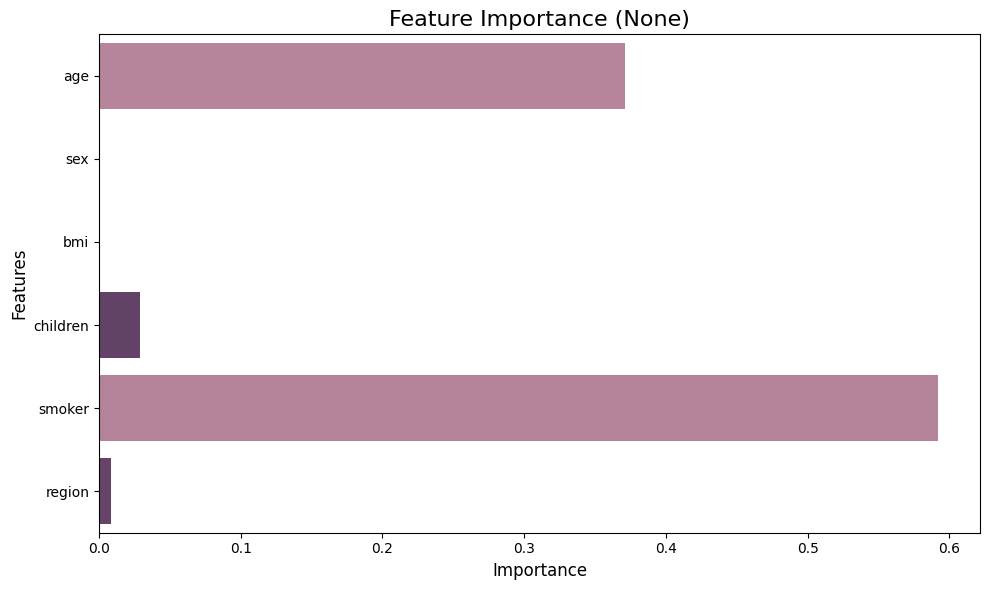

<Figure size 640x480 with 0 Axes>

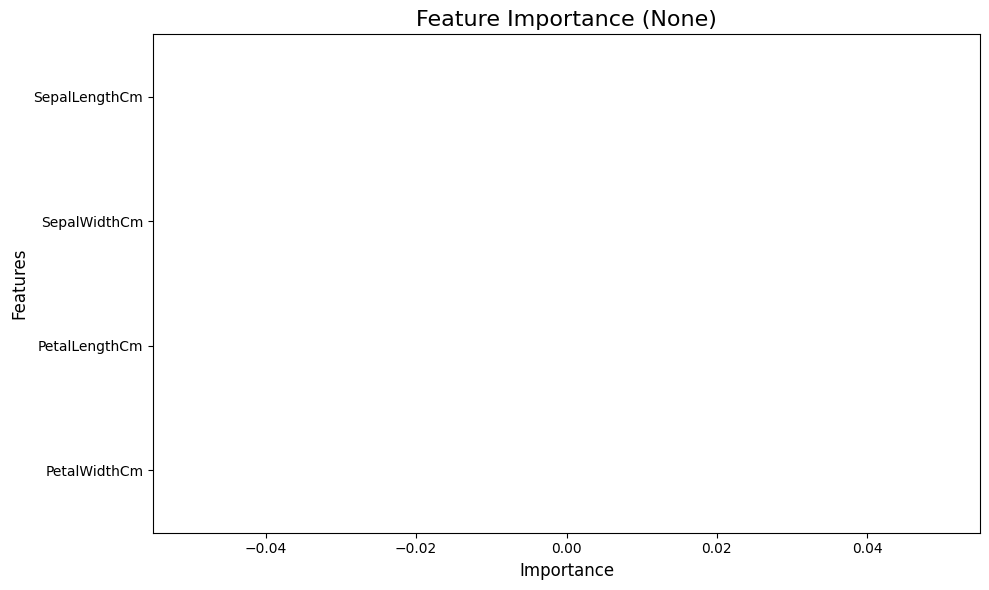

<Figure size 640x480 with 0 Axes>

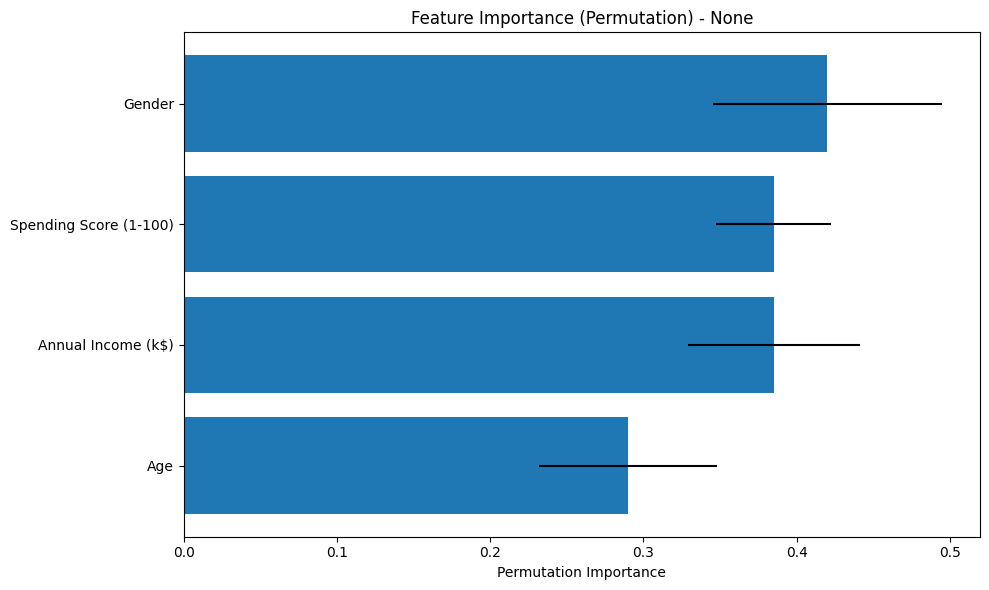

<Figure size 640x480 with 0 Axes>

In [54]:
# Testing Feature Importance Visualization

for fi_df, task_type in zip(fi_df_list, task_type_list, ):
    
    # print(fi_df, '\n')
    
    feature_importance_visualization(fi_df, task_type)